In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import exp.nb_03Magda as exp03

In [3]:
train_x, train_y, valid_x, valid_y, test_x, test_y = exp03.get_mnist()

In [4]:
from functools import partial
norm_by_train = partial(exp03.normalize, data_for_stats=train_x)
train_x, valid_x, test_x = [norm_by_train(data_to_norm=x) for x in (train_x, valid_x, test_x)]

## Data bunch / learner

In [5]:
#export
from torch.utils.data import TensorDataset, DataLoader

class DataBunch():
    def __init__(self, train_in, train_trg, valid_in, valid_trg, train_bs, valid_bs=None):
        self.train_data = TensorDataset(train_in, train_trg)
        self.valid_data = TensorDataset(valid_in, valid_trg)
        self.train_bs = train_bs
        self.valid_bs = len(valid_in) if valid_bs is None else valid_bs
    
    @property
    def train_dl(self):
        return DataLoader(self.train_data, self.train_bs, shuffle=True)
        
    @property
    def valid_dl(self):
        return DataLoader(self.valid_data, self.valid_bs, shuffle=False)

In [6]:
mnist_bunch = DataBunch(train_x, train_y, valid_x, valid_y, 5000)

### fit loop

In [ ]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

class Learner():
    def __init__(self, data_bunch, callbacks):
        self.data_bunch = data_bunch
        self._get_model()
        self._get_optimizer()
        self._loss_func()

    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), nn.Linear(num_hidden, num_out))

    def _get_optimizer(self, lr=0.5):
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        
    def _loss_func(self):
        self.loss_func = F.cross_entropy

    def get_accuracy(self, logits, targets):
        preds = logits.argmax(1)
        return (preds==targets).float().mean()
    
    def train_one_batch(self, bx, by):
        self.callbacks.on_batch_begin()
        outs = self.model(bx)
        loss = self.loss_func(outs, by)
        self.callbacks.on_backward_begin()
        loss.backward()
        self.callbacks.on_step_begin()
        self.optimizer.step()
        self.callbacks.on_step_end()
        self.optimizer.zero_grad()
        self.callbacks.on_batch_end()
        return loss
    
    def train_one_epoch(self):
        loss = 0.
        self.callbacks.on_epoch_begin()
        for bidx, (batch_x, batch_y) in enumerate(self.data_bunch.train_dl):
            loss += self.train_one_batch(batch_x, batch_y).item()
        self.callbacks.on_epoch_end()
        return loss / (bidx + 1.)
    
    def validate(self):
        loss = 0.
        accuracy = 0.
        self.callbacks.on_valid_begin()
        for bidx, (batch_x, batch_y) in enumerate(self.data_bunch.valid_dl):
            self.callbacks.on_valid_batch_begin()
            outs = self.model(batch_x)
            loss = self.loss_func(outs, batch_y)
            accuracy = self.get_accuracy(outs, batch_y)
        self.callbacks.on_valid_end()
        return loss.item() / (bidx + 1.), accuracy.item() / (bidx + 1.)
    
    def train(self, epochs):
        train_losses = []
        valid_losses = []
        valid_accuracy = []
        self.callbacks.on_train_begin()
        for epoch in range(epochs):
            self.model.train()
            loss = self.train_one_epoch()
            train_losses.append(loss)
            self.model.eval()
            with torch.no_grad():
                loss, accuracy = self.validate()
            valid_losses.append(loss)
            valid_accuracy.append(accuracy)
        self.callbacks.on_train_end()
        return train_losses, valid_losses, valid_accuracy

In [ ]:
learner = Learner(mnist_bunch)

In [ ]:
train_losses, valid_losses, valid_accuracy = learner.train(10)

In [ ]:
learner.data_bunch.train_dl

In [ ]:
import torch
def fit(learner, epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        learner.model.train()
        losses = 0.
        for bidx, (batch_x, batch_y) in enumerate(learner.data_bunch.train_dl):
            outs = learner.model(batch_x)
            loss = learner.loss_func(outs, batch_y)
            loss.backward()
            learner.optimizer.step()
            learner.optimizer.zero_grad()
            losses += loss.item()
        train_losses.append(losses / (bidx + 1.))
        learner.model.eval()
        with torch.no_grad():
            losses = 0.
            accuracies = 0.
            for bidx, (batch_x, batch_y) in enumerate(learner.data_bunch.valid_dl):
                outs = learner.model(batch_x)
                losses += learner.loss_func(outs, batch_y).item()
                accuracies += learner.get_accuracy(outs, batch_y).item()
            valid_losses.append(losses / (bidx + 1.))
            valid_accuracies.append(accuracies / (bidx + 1.))
    return (train_losses, valid_losses, valid_accuracies)

In [ ]:
metrics = fit(learner, 10)
train_losses, valid_losses, valid_accuracies = metics

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
axs[0].legend()
axs[0].set_title('Losses')

axs[1].plot(valid_accuracies)
axs[1].set_title('Accuracy')

fig.set_size_inches((10, 5))

In [ ]:
def train_epoch(batch_x, batch_y, callbacks):
    out
for bidx, (batch_x, batch_y) in enumerate(learner.data_bunch.train_dl):
            outs = learner.model(batch_x)
            loss = learner.loss_func(outs, batch_y)
            loss.backward()
            learner.optimizer.step()
            learner.optimizer.zero_grad()
            losses += loss.item()
        train_losses.append(losses / (bidx + 1.))
        learner.model.eval()


## Callbacks

In [15]:
#export
def get_accuracy(self, logits, targets):
    preds = logits.argmax(1)
    return (preds==targets).float().mean()

In [16]:
#export
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

class Learner():
    def __init__(self, data_bunch, callback_list=None):
        self.data_bunch = data_bunch
        self._get_model()
        self._get_optimizer()
        self._loss_func()
        self.callback_list = callback_list
        self.epoch = 0
        self.batch_x = None
        self.batch_y = None
        self.metrics = {}

    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), nn.Linear(num_hidden, num_out))

    def _get_optimizer(self, lr=0.5):
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        
    def _loss_func(self):
        self.loss_func = F.cross_entropy

    def forward(self, bx, by):
        logits = self.model(bx)
        loss = self.loss_func(logits, by)
        return logits, loss
    
    def backward(self, loss):
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
       
    def fit(self, epochs):
        self.callback('fit_begin')
        for self.epoch in range(epochs):
            self.model.train()
            self.callback('train_begin')
            for (self.batch_x, self.batch_y) in self.data_bunch.train_dl:
                logits, loss = self.forward(self.batch_x, self.batch_y)
                self.backward(loss)
                self.callback('train_batch_end', logits, loss)
            self.model.eval()
            with torch.no_grad():
                self.callback('validation_begin')
                for (self.batch_x, self.batch_y) in self.data_bunch.valid_dl:
                    logits, loss = self.forward(self.batch_x, self.batch_y)
                    self.callback('validation_batch_end', logits, loss)
            self.callback('epoch_end')
        self.callback('fit_end')
    
    def callback(self, cb_name, *args, **kwargs):
        if self.callback_list:
            for cb in self.callback_list:
                cb_method = getattr(cb, cb_name, None)
                if cb_method:
                    cb.init_learner(self)
                    cb_method(*args, **kwargs)

In [17]:
#export
class Callback():
    "Base class for callbacks"
    def init_learner(self, learner):
        self.learner = learner

In [18]:
#export
class AccuracyCallback(Callback):
    def fit_begin(self):
        self.accuracies = []
        
    def validation_begin(self):
        self.num_correct = 0.
        self.num_total = 0.
        
    def validation_batch_end(self, logits, *args, **kwargs):
        preds = logits.argmax(1)
        targets = learner.batch_y
        self.num_correct += (preds==targets).float().sum()
        self.num_total += len(logits)
        
    def epoch_end(self):
        accuracy = self.num_correct / self.num_total
        self.accuracies.append(accuracy)
        
    def fit_end(self):
        learner.metrics['val_accuracies'] = self.accuracies
        print(f'Final accuracy: {self.accuracies[-1]:4.6f}')

In [19]:
#export
class LossCallback(Callback):
    def fit_begin(self):
        self.train_losses = []
        self.valid_losses = []
        
    def train_begin(self):
        self.t_loss_total = 0.
        self.t_num_total = 0.
        
    def train_batch_end(self, logits, loss, *args, **kwargs):
        num_instances = len(logits)
        self.t_num_total += num_instances
        self.t_loss_total += loss * num_instances

    def validation_begin(self):
        self.v_loss_total = 0.
        self.v_num_total = 0.
        
    def validation_batch_end(self, logits, loss, *args, **kwargs):
        num_instances = len(logits)
        self.v_num_total += num_instances
        self.v_loss_total += loss * num_instances
        
    def epoch_end(self):
        t_loss = self.t_loss_total / self.t_num_total
        v_loss = self.v_loss_total / self.v_num_total
        self.train_losses.append(t_loss)
        self.valid_losses.append(v_loss)
        
    def fit_end(self):
        learner.metrics['train_losses'] = self.train_losses
        learner.metrics['valid_losses'] = self.valid_losses

In [20]:
#export
import matplotlib.pyplot as plt
class PlotsCallback(Callback):
    def fit_end(self):
        metrics_fig = plt.figure(figsize=(10,5))
        if 'train_losses' in learner.metrics:
            ax = metrics_fig.add_subplot(1, 2, 1)
            ax.plot(learner.metrics['train_losses'], label='train')
            ax.plot(learner.metrics['valid_losses'], label='valid')
            ax.set_title('Losses')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Cross_entropy')
            ax.legend()
        if 'val_accuracies' in learner.metrics:
            ax = metrics_fig.add_subplot(1, 2, 2)
            ax.plot(learner.metrics['val_accuracies'])
            ax.set_title('Validation accuracy')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy (%)')                

In [21]:
callbacks = [AccuracyCallback(), LossCallback(), PlotsCallback()]

Final accuracy: 0.937900


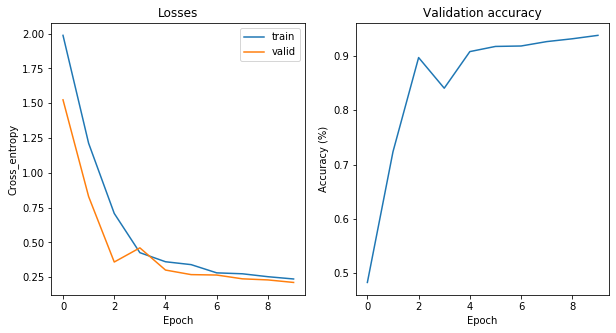

In [22]:
learner = Learner(mnist_bunch, callbacks)
learner.fit(10)

In [23]:
!python notebook2script.py 04Magda_callbacks.ipynb

Converted 04Magda_callbacks.ipynb to exp/nb_04Magda.py
